<a href="https://colab.research.google.com/github/purvilmehta06/Deep-Learning/blob/master/Lab%209/labAssignment9_201701073.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9: Deep Learning


*   Lab Manual: [Manual Lab 9](https://github.com/purvilmehta06/Deep-Learning/blob/master/Lab%209/Lab_Assignment_9.pdf)
*   Author: Purvil Mehta
*   Id : 201701073
*   Github Link : [Deep Learning Course Lab Work Repo](https://github.com/purvilmehta06/Deep-Learning)

In [1]:
from tensorflow.keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout,Input, Dense, Layer, InputSpec, UpSampling2D, Reshape, BatchNormalization, Conv2D, MaxPooling2D, Flatten,LeakyReLU,Conv2DTranspose
import numpy as np
from numpy.random import randn, randint
from tensorflow import keras
import tensorflow as tf
from numpy import vstack
import matplotlib.pyplot as plt
from tensorflow.python.keras import regularizers
from keras.optimizers import Adam
from tensorflow.keras import initializers
from keras import regularizers, activations, initializers,constraints, Sequential
from keras.constraints import UnitNorm, Constraint
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.datasets.mnist import load_data
from tensorflow.keras import optimizers
import time

In [2]:
(trainX, trainy), (testX, testy) = load_data()
trainX = trainX/255.0
testX = testX/255.0 
trainX = trainX.reshape([60000,28,28,1])
testX = testX.reshape([10000,28,28,1])

11493376/11490434 [==============================] - 0s 0us/step


# Model Initialisation

In [3]:
def getD():
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [4]:
def getG(inputPoints):
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=inputPoints))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

In [5]:
def getGAN(modelD,modelG):
  modelD.trainable = False
  model = Sequential()
  model.add(modelG)
  model.add(modelD)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

# Supporting Functions

In [6]:
def generateData(dim,totalPoints):
  x_sample = randn(dim * totalPoints)
  x_sample = x_sample.reshape(totalPoints,dim)
  return x_sample

def getRealdata(totalPoints):
  index = randint(0, trainX.shape[0], totalPoints)
  realX = trainX[index]
  realY = np.ones((totalPoints,1))
  return realX,realY

def getFakedata(modelG,dim,totalPoints):
  fakeX = generateData(dim,totalPoints)
  fakeX = modelG.predict(fakeX)
  fakeY = np.zeros((totalPoints,1))
  return fakeX, fakeY  

In [7]:
def save_plot(fakeX, epoch):
  plt.figure(figsize=(18,8))
  for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis('off')
    plt.imshow(fakeX[i, :, :, 0], cmap='gray')
  filename = 'epoch_' + str(epoch) + '.png'
  plt.savefig(filename)
  plt.close()

# Task 1: Train GAN to generate MNIST dataset 

In [ ]:
inputPoints = 100
modelD = getD()
modelG = getG(inputPoints)
modelGAN = getGAN(modelD,modelG)
epochs = 50
batchSize = 300
totalSteps = trainX.shape[0]//batchSize
d_loss_history = []
g_loss_history = []
for i in range(epochs):
  d_loss_avg = 0
  g_loss_avg = 0
  start = time.time() 
  if (i==0 or i==(epochs//2) or i==(epochs-1)):
    fakeX, fakeY = getFakedata(modelG,inputPoints,30)
    save_plot(fakeX,i)
  for j in range(totalSteps):
    realX, realY = getRealdata(batchSize//2)
    fakeX, fakeY = getFakedata(modelG,inputPoints,batchSize//2)
    finalX, finalY = vstack((realX, fakeX)), vstack((realY, fakeY))
    modelD.trainable = True
    d_loss, _ = modelD.train_on_batch(finalX, finalY)
    genX = generateData(inputPoints,batchSize)
    genY = np.ones((batchSize,1))
    g_loss = modelGAN.train_on_batch(genX, genY)
    d_loss_avg += d_loss
    g_loss_avg += g_loss

  print('Epoch: {}/{} || Time: {}s || G_Loss: {} || D_Loss: {}'.format(i+1,epochs,round(time.time()-start,5), 
                                                                       round(g_loss_avg/totalSteps,8),(d_loss_avg/totalSteps)))
  d_loss_history.append(d_loss_avg/totalSteps)
  g_loss_history.append(g_loss_avg/totalSteps)
modelG.save_weights('g.h5')

Epoch: 1/50 || Time: 27.61057s || G_Loss: 0.98846653 || D_Loss: 0.4846308839321136
Epoch: 2/50 || Time: 26.62901s || G_Loss: 0.93353134 || D_Loss: 0.6283672218024731
Epoch: 3/50 || Time: 26.29555s || G_Loss: 0.71998464 || D_Loss: 0.6830315533280372
Epoch: 4/50 || Time: 26.37642s || G_Loss: 0.72312777 || D_Loss: 0.6895887663960457
Epoch: 5/50 || Time: 26.2481s || G_Loss: 0.72605587 || D_Loss: 0.6832615044713021
Epoch: 6/50 || Time: 26.29255s || G_Loss: 0.71676193 || D_Loss: 0.687653891146183
Epoch: 7/50 || Time: 26.50039s || G_Loss: 0.72675621 || D_Loss: 0.6838962349295616
Epoch: 8/50 || Time: 26.33229s || G_Loss: 0.71713022 || D_Loss: 0.6881537958979607
Epoch: 9/50 || Time: 26.43437s || G_Loss: 0.71755598 || D_Loss: 0.6872888997197151
Epoch: 10/50 || Time: 26.17639s || G_Loss: 0.71418034 || D_Loss: 0.6896842926740646
Epoch: 11/50 || Time: 26.12047s || G_Loss: 0.73420892 || D_Loss: 0.6939305663108826
Epoch: 12/50 || Time: 26.6502s || G_Loss: 0.70333568 || D_Loss: 0.6868601006269455
Epoc

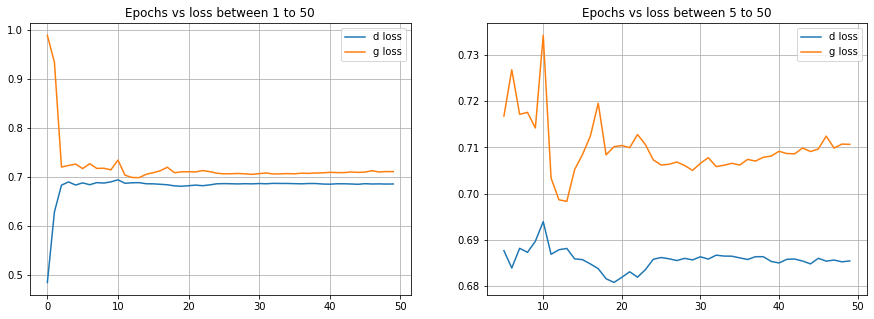

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(d_loss_history[:])
plt.plot(g_loss_history[:])
plt.legend(['d loss','g loss'])
plt.title('Epochs vs loss between 1 to 50')
plt.grid()
plt.subplot(1,2,2)
plt.plot(np.arange(5,50,1,dtype=int),d_loss_history[5:])
plt.plot(np.arange(5,50,1,dtype=int),g_loss_history[5:])
plt.legend(['d loss','g loss'])
plt.title('Epochs vs loss between 5 to 50')
plt.grid()
plt.show()

* Here, both G and D netorks tries to overcome each other's losses to get better rewards in the next iteration. 
* When G loss increses, D loss decreaes and vice versa

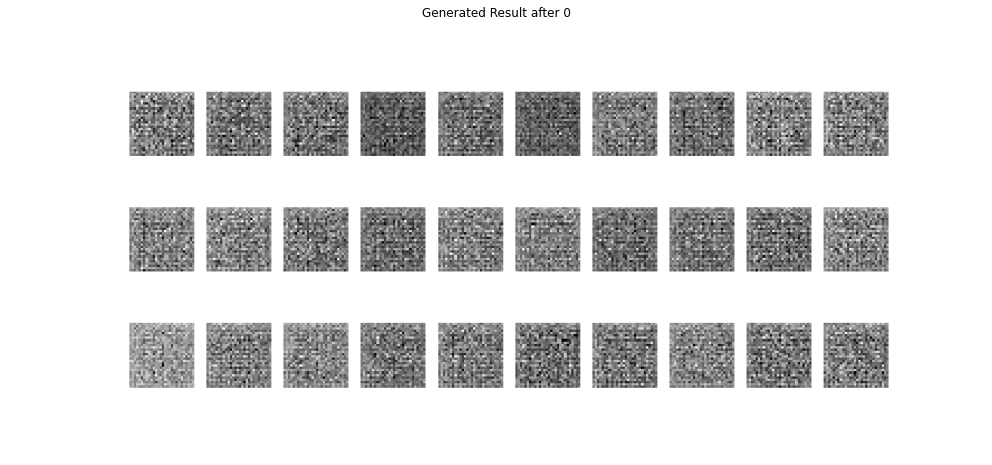

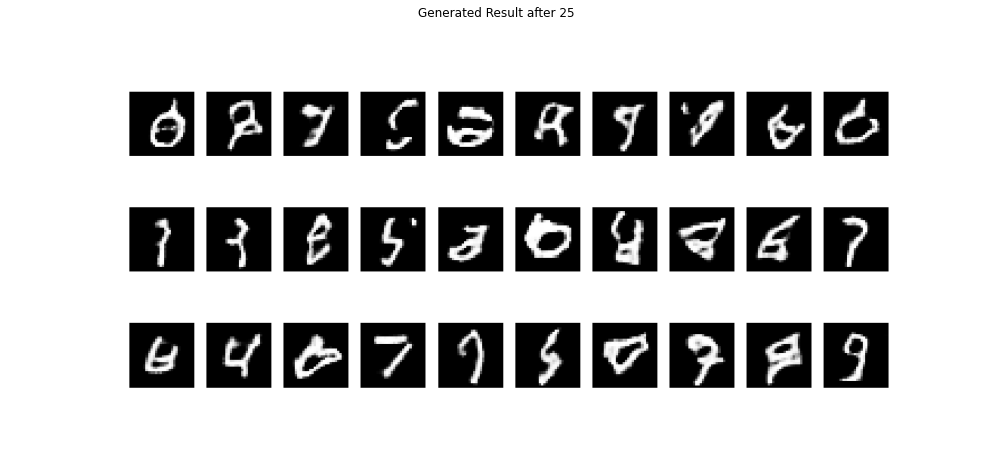

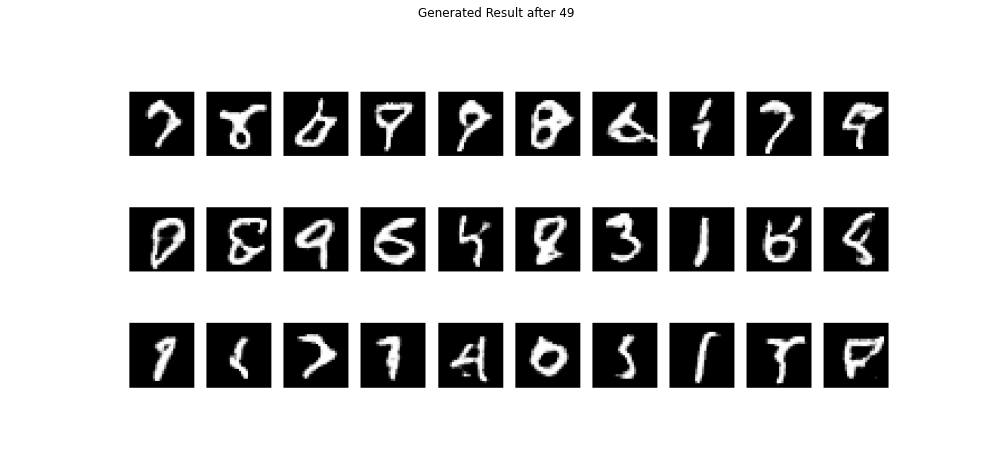

In [ ]:
epoch = [0,25,49]
for i in range(3):
  plt.figure(figsize=(18,8))
  filename = '/content/epoch_' + str(epoch[i]) + '.png'
  img = plt.imread(filename)
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.title('Generated Result after '+str(epoch[i]))
  plt.show()

* Looking at the results, it is clear that the D and G network tries to compete with each other. One tries to do better than the other one. By looking at the images, it is also evident that the result generated after full training is much more better than the result generated after half training
* Also, it is evident that the result in the before training has just a random weigths. This caused the randomisation in the result. 

# Task 2: Interpolating between two GAN images 

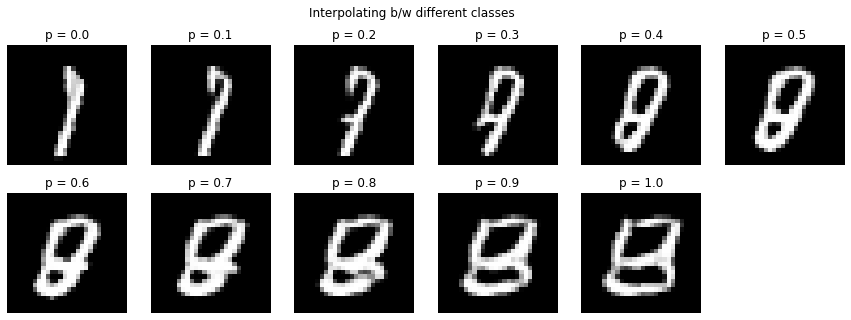

In [21]:
#modelG = getG(100)
#modelG.load_weights('g.h5')
# Generating random 100 points 
input1 = generateData(100,1)
input2 = generateData(100,1)
p = np.arange(0,1.1,0.1)
plt.figure(figsize=(15,5))
for i in range(len(p)):
  plt.subplot(2,6,i+1)
  # Interpolating between two random points => pass it to generator to get see how classes changes
  new_img = p[i]*input1 + (1-p[i])*input2
  new_img = modelG.predict(new_img)
  plt.imshow(new_img[0,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('p = {}'.format(round(p[i],2)))
plt.suptitle('Interpolating b/w different classes')
plt.show()

* When p = 0 => one class is choosed
* When p = 1 => second class is choosed
* When 0 < p < 1 => Combination/Evolution of one class from the second class is shown.

# Task 3: Adding Data to MNIST and Training

## Data Addition

In [ ]:
#modelG = getG(100)
#modelG.load_weights('g.h5')
fakeX, fakeY = getFakedata(modelG,100,5000) 
trainAddedX = vstack((trainX,fakeX))
trainAddedX_noise = trainAddedX + 50*np.random.normal(0,1,size=trainAddedX.shape)/255.0 
testX_noise = testX + 50*np.random.normal(0,1,size=testX.shape)/255.0
p = np.array(np.arange(trainAddedX.shape[0]))
np.random.shuffle(p)
trainAddedX_noise = trainAddedX_noise[p,:,:,:]
trainAddedX = trainAddedX[p,:,:,:]
print(trainX.shape,fakeX.shape,trainAddedX.shape)
trainX_noise = trainX + 50*np.random.normal(0,1,size=trainX.shape)/255.0

(60000, 28, 28, 1) (5000, 28, 28, 1) (65000, 28, 28, 1)


## Sample Images 

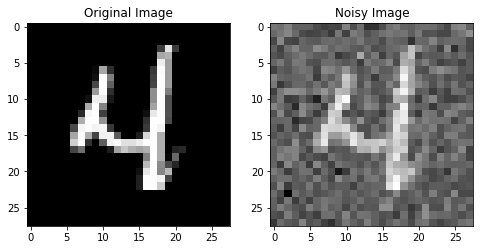

In [ ]:
example_image = 111
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(trainAddedX[example_image,:,:,0],cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(trainAddedX_noise[example_image,:,:,0],cmap='gray')
plt.title('Noisy Image')
plt.show()

## Denoising on Added Dataset

In [ ]:
def getModelDenoise():
  model = Sequential()
  model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(6272,activation='relu'))
  model.add(Reshape((14,14,32)))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))
  model.compile('adam',loss='mse',metrics=['mse'])
  return model

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               3211776   
_________________________________________________________________
dense_11 (Dense)             (None, 6272)              3217536   
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 32)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 32)      

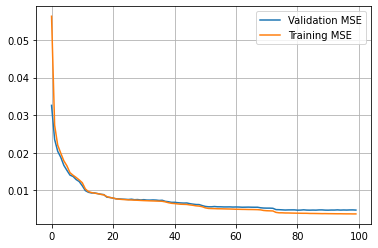

In [ ]:
addedModel = getModelDenoise()
addedModel.summary()
history = addedModel.fit(trainAddedX_noise, trainAddedX, epochs=100, batch_size=550, validation_data=(testX_noise,testX), verbose=0)
print("Model is trained with training mse: {}".format(history.history['mse'][-1]))

plt.figure()
plt.plot(history.history['val_mse'])
plt.plot(history.history['mse'])
plt.legend(['Validation MSE','Training MSE'])
plt.grid()
plt.show()

* Here MSE remains the same for both the validation and testing set. If we reduces the epochs by applying early stoping, then it might happen we found the change in testing and training MSE.

## Visualising Reconstructed Images 

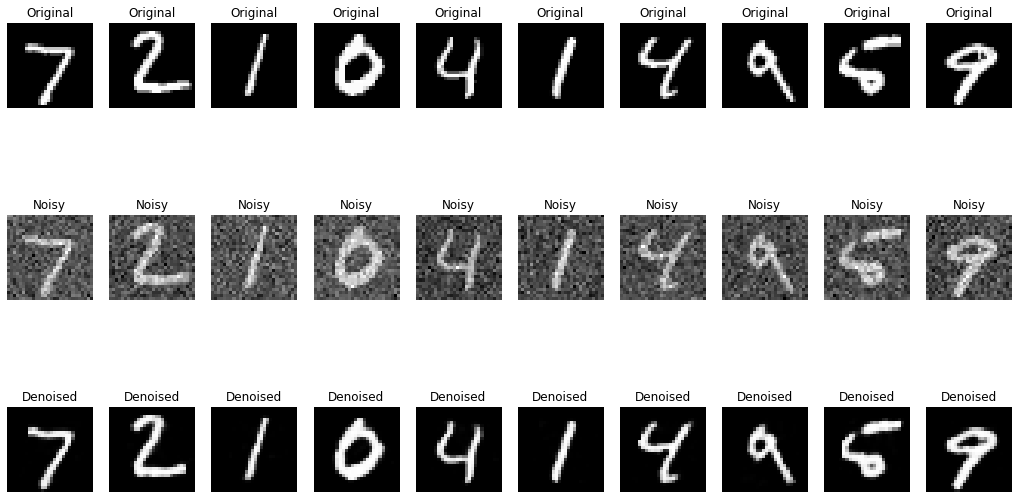

In [ ]:
reconstructedImages = addedModel.predict(testX_noise)
plt.figure(figsize=(18, 10))
n = 10
for i in range(n):
  # display original
  plt.subplot(3, n, i + 1)
  plt.imshow(testX[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Original')

  # display reconstruction
  plt.subplot(3, n, i+1+n)
  plt.imshow(testX_noise[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Noisy')

  # display reconstruction
  plt.subplot(3, n, i+1+2*n)
  plt.imshow(reconstructedImages[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Denoised')
plt.show()

* Reconstructed image has zero noise now. I ran this exeperiment on testing set provided in the MNIST loader.  

## Denoising on normal MNIST Dataset

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               3211776   
_________________________________________________________________
dense_13 (Dense)             (None, 6272)              3217536   
_________________________________________________________________
reshape_3 (Reshape)          (None, 14, 14, 32)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 32)      

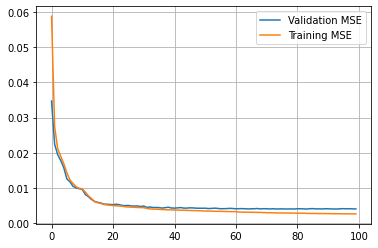

In [ ]:
model = getModelDenoise()
model.summary()
history1 = model.fit(trainX_noise, trainX, epochs=100, batch_size=550, validation_data=(testX_noise,testX), verbose=0)
print("Model is trained with training mse: {}".format(history.history['mse'][-1]))

plt.figure()
plt.plot(history1.history['val_mse'])
plt.plot(history1.history['mse'])
plt.legend(['Validation MSE','Training MSE'])
plt.grid()
plt.show()

## Comparision Between two models

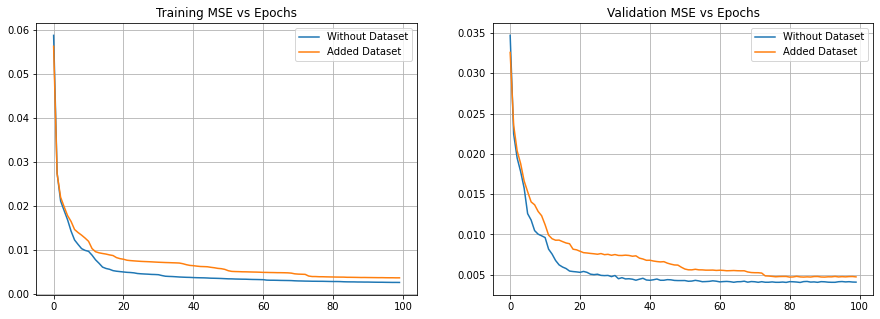

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history1.history['mse'])
plt.plot(history.history['mse'])
plt.legend(['Without Dataset','Added Dataset'])
plt.title('Training MSE vs Epochs')
plt.grid()
plt.subplot(1,2,2)
plt.plot(history1.history['val_mse'])
plt.plot(history.history['val_mse'])
plt.legend(['Without Dataset','Added Dataset'])
plt.title('Validation MSE vs Epochs')
plt.grid()
plt.show()

* There is one difference I can easily notice is that the model with the data added from the GAN perfoms marginally poor than the actual one. As it might happen that the data provided by the G might not be the accurate. This cause the MSE error while doing the denoising. 
* We also observe the same trend in the validation MSE as well. 